### To Do

1. Sanity check first [done]
1. Band power with respect to stimulus onset -> to check if LFP is properly aligned [done]
2. Calculate hidden state distribution for each stimulus [done]
4. UMAP LFP inputs (should match the figure on the paper) [done]
4. Use LL to determine the optimum number of hidden states [done]
5. Calculate hidden state distributions with respect to hit and miss trials [done]
5. Delve into the means (result should resemble the power matrix) [done]
6. Compare the hit and miss trials [done]
> today
1. Make sure the model also works for none down-sampled LFPs [done] - yes
2. Make sure different bands works for none down-sampled LFPs [done] - not quite
3. Make sure down sampled LFP (5x) works for the different bands [done] - note quite
4. Make a plan
> just for fun lol
1. Try to find recurring patterns/sequences
1. Try to fix the spectrogram
1. Repeat with Day 1 session to see if similar results can be found

### Libraries and dependencies

In [2]:
import gc
import umap
import numpy as np
import pandas as pd
from hmmlearn import hmm
from tqdm import tqdm
from copy import deepcopy
from scipy.stats import zscore, mode, entropy, sem
from matplotlib import pyplot as plt
from scipy.signal import butter, sosfiltfilt, hilbert, decimate, stft
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache
output_dir = "E:/jerry/vbn_s3_cache"
cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=output_dir)

e:\jerry\anaconda\envs\allensdk\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1055221968 day 1

In [3]:
session = cache.get_ecephys_session(ecephys_session_id=1055221968) # type: ignore
probeA = session.get_lfp(1055328904) #VISam
probeB = session.get_lfp(1055328905) #VISpm
probeC = session.get_lfp(1055328906) #VISp
probeD = session.get_lfp(1055328908) #VISl
probeE = session.get_lfp(1055328909) #VISal
probeF = session.get_lfp(1055328910) #VISrl

### 1055403683 day2

In [267]:
session = cache.get_ecephys_session(ecephys_session_id=1055403683) # type: ignore
probeA = session.get_lfp(1055529304) #VISam
probeB = session.get_lfp(1055529306) #VISpm
probeC = session.get_lfp(1055529307) #VISp
probeD = session.get_lfp(1055529308) #VISl
probeE = session.get_lfp(1055529309) #VISal
probeF = session.get_lfp(1055529310) #VISrl

KeyboardInterrupt: 

### Stims

In [4]:
# getting the start and end of stim block 0
sp = session.stimulus_presentations
sp = sp[sp['stimulus_block'] == 0]
start = sp.iloc[0].start_time
end = sp.iloc[-1].end_time
# 1000ms buffer in both ends, 250ms before start, 1250Hz sampling rate
imgs = np.unique(sp['image_name'].values)

omitted = sp[sp['omitted']==True]
miss = sp[(sp['is_change']==True) & (sp['rewarded']==False)]
hit = sp[(sp['is_change']==True) & (sp['rewarded']==True)]

Day 1: ['im012_r', 'im036_r', 'im044_r', 'im047_r', 'im078_r', 'im083_r', 'im111_r', 'im115_r', 'omitted']
<br>
Day 2: ['im005_r', 'im024_r', 'im034_r', 'im083_r', 'im087_r', 'im104_r', 'im111_r', 'im114_r', 'omitted']

### Slicing LFP

In [5]:
def find_nearest_idx(array, value):
    idxs = np.zeros(len(value), dtype=int)
    for i, v in enumerate(value):
        idx = np.argmin(np.abs(np.array(array) - v))
        idxs[i] = idx
    return idxs

In [6]:
master_time = np.arange(start-0.25-1, end+1, 1/1250)

In [17]:
chan = session.get_channels()
probes = [probeA, probeB, probeC, probeD, probeE, probeF]

In [16]:
for i in probes:
    print(np.unique(chan.loc[i.channel].structure_acronym.values))

['APN' 'CA1' 'DG' 'MB' 'VISam' 'root']
['APN' 'CA1' 'DG' 'MB' 'POL' 'TH' 'VISpm' 'root']
['HPF' 'MB' 'MRN' 'POST' 'SCig' 'VISp' 'root']
['CA1' 'CA3' 'DG' 'MB' 'MGv' 'TH' 'VISl' 'ZI' 'root']
['CA1' 'DG' 'MRN' 'POL' 'PoT' 'SGN' 'VISal' 'root']
['CA1' 'CA3' 'DG' 'LP' 'MGm' 'PoT' 'SGN' 'TH' 'VISrl' 'root']


In [18]:
vis_names = ['VISam', 'VISpm', 'VISp', 'VISl', 'VISal', 'VISrl']
lfp = np.zeros((len(vis_names), len(master_time)))

In [28]:
for i in range(len(probes)):
    probe = probes[i]
    probe_chans = chan.loc[probe.channel]
    probe_chans = probe_chans[probe_chans['structure_acronym']==vis_names[i]]
    print(probe_chans.probe_vertical_position)
    ids = probe_chans.index
    id_select = ids[int(len(ids)*0.3)]
    print(id_select)
    probe_chan = probe.sel(channel=id_select)
    probe_chan_sel = probe_chan.sel(time=master_time, method='nearest')
    lfp[i] = probe_chan_sel
    display(probe_chans.loc[id_select])

id
1160408380    2520
1160408385    2560
1160408389    2600
1160408393    2640
1160408397    2680
1160408402    2720
1160408407    2760
1160408411    2800
1160408415    2840
1160408419    2880
1160408423    2920
1160408427    2960
1160408431    3000
1160408435    3040
1160408439    3080
1160408443    3120
Name: probe_vertical_position, dtype: int64
1160408397


anterior_posterior_ccf_coordinate                                               7712.0
dorsal_ventral_ccf_coordinate                                                   1011.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7753.0
probe_channel_number                                                               266
probe_horizontal_position                                                           59
probe_id                                                                    1055328904
probe_vertical_position                                                           2680
structure_acronym                                                                VISam
Name: 1160408397, dtype: object

id
1160408800    2640
1160408805    2680
1160408809    2720
1160408814    2760
1160408819    2800
1160408823    2840
1160408827    2880
1160408831    2920
1160408835    2960
1160408839    3000
1160408843    3040
1160408847    3080
1160408851    3120
1160408856    3160
1160408860    3200
1160408864    3240
1160408868    3280
1160408872    3320
1160408876    3360
Name: probe_vertical_position, dtype: int64
1160408823


anterior_posterior_ccf_coordinate                                               8041.0
dorsal_ventral_ccf_coordinate                                                    987.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7619.0
probe_channel_number                                                               282
probe_horizontal_position                                                           59
probe_id                                                                    1055328905
probe_vertical_position                                                           2840
structure_acronym                                                                VISpm
Name: 1160408823, dtype: object

id
1160409207    2680
1160409211    2720
1160409215    2760
1160409219    2800
1160409223    2840
1160409227    2880
1160409231    2920
1160409235    2960
1160409239    3000
1160409243    3040
1160409247    3080
1160409251    3120
1160409255    3160
1160409259    3200
1160409263    3240
1160409267    3280
1160409271    3320
1160409276    3360
Name: probe_vertical_position, dtype: int64
1160409227


anterior_posterior_ccf_coordinate                                               9201.0
dorsal_ventral_ccf_coordinate                                                   1242.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       7899.0
probe_channel_number                                                               286
probe_horizontal_position                                                           59
probe_id                                                                    1055328906
probe_vertical_position                                                           2880
structure_acronym                                                                 VISp
Name: 1160409227, dtype: object

id
1160409616    2800
1160409620    2840
1160409624    2880
1160409628    2920
1160409632    2960
1160409636    3000
1160409640    3040
1160409644    3080
1160409648    3120
1160409652    3160
1160409656    3200
1160409660    3240
1160409664    3280
1160409668    3320
1160409673    3360
1160409677    3400
1160409681    3440
1160409685    3480
1160409689    3520
1160409693    3560
1160409697    3600
Name: probe_vertical_position, dtype: int64
1160409640


anterior_posterior_ccf_coordinate                                               8893.0
dorsal_ventral_ccf_coordinate                                                   1913.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       9208.0
probe_channel_number                                                               302
probe_horizontal_position                                                           59
probe_id                                                                    1055328908
probe_vertical_position                                                           3040
structure_acronym                                                                 VISl
Name: 1160409640, dtype: object

id
1160410016    2800
1160410020    2840
1160410024    2880
1160410028    2920
1160410032    2960
1160410036    3000
1160410040    3040
1160410044    3080
1160410048    3120
1160410052    3160
1160410056    3200
1160410060    3240
1160410066    3280
1160410070    3320
1160410074    3360
1160410078    3400
1160410082    3440
Name: probe_vertical_position, dtype: int64
1160410036


anterior_posterior_ccf_coordinate                                               8381.0
dorsal_ventral_ccf_coordinate                                                   1650.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       9090.0
probe_channel_number                                                               298
probe_horizontal_position                                                           59
probe_id                                                                    1055328909
probe_vertical_position                                                           3000
structure_acronym                                                                VISal
Name: 1160410036, dtype: object

id
1160410364    2320
1160410368    2360
1160410372    2400
1160410376    2440
1160410380    2480
1160410386    2520
1160410390    2560
1160410394    2600
1160410398    2640
1160410402    2680
1160410406    2720
1160410410    2760
1160410414    2800
1160410418    2840
1160410422    2880
1160410426    2920
1160410430    2960
1160410434    3000
Name: probe_vertical_position, dtype: int64
1160410386


anterior_posterior_ccf_coordinate                                               7663.0
dorsal_ventral_ccf_coordinate                                                   1661.0
filtering                            AP band: 500 Hz high-pass; LFP band: 1000 Hz l...
left_right_ccf_coordinate                                                       8994.0
probe_channel_number                                                               250
probe_horizontal_position                                                           59
probe_id                                                                    1055328910
probe_vertical_position                                                           2520
structure_acronym                                                                VISrl
Name: 1160410386, dtype: object

In [165]:
# don't use these anymore, will delete them soon
lfpA_slice = probeA.sel(time=master_time, method='nearest')
lfpB_slice = probeB.sel(time=master_time, method='nearest')
lfpC_slice = probeC.sel(time=master_time, method='nearest')
lfpD_slice = probeD.sel(time=master_time, method='nearest')
lfpE_slice = probeE.sel(time=master_time, method='nearest')
lfpF_slice = probeF.sel(time=master_time, method='nearest')
lfpA_copy = deepcopy(lfpA_slice)
lfpB_copy = deepcopy(lfpB_slice)
lfpC_copy = deepcopy(lfpC_slice)
lfpD_copy = deepcopy(lfpD_slice)
lfpE_copy = deepcopy(lfpE_slice)
lfpF_copy = deepcopy(lfpF_slice)

In [166]:
mask = np.array([23])
A_chan = lfpA_copy[:,mask]
B_chan = lfpB_copy[:,mask]
C_chan = lfpC_copy[:,mask]
D_chan = lfpD_copy[:,mask]
E_chan = lfpE_copy[:,mask]
F_chan = lfpF_copy[:,mask]

In [94]:
print(A_chan.shape == B_chan.shape == C_chan.shape == D_chan.shape == E_chan.shape == F_chan.shape) # should all be the same

True


### GaussianHMM

#### LL and elbow test

In [ ]:
ns = np.arange(2,21)
lls = np.zeros(len(ns))
for i, n in tqdm(enumerate(ns)):
    ll_temp = 0
    for iter in range(3):
        model = hmm.GaussianHMM(n_components=n, n_iter=1000, verbose=False, tol=0.1)
        model.fit(bands_z_0)
        ll_temp+=model.score(bands_z_0)
    lls[i] = ll_temp/3

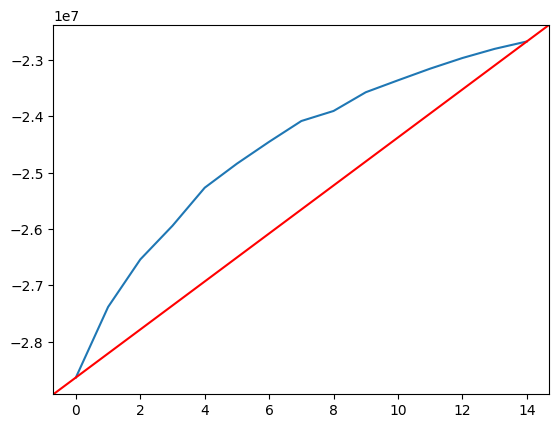

In [373]:
plt.plot(np.arange(len(lls)-4), lls[:-4])
plt.axline((0, lls[0]), (len(lls)-5, lls[-5]), c='r')

In [378]:
lls_new = lls[:-4]
slope = (lls_new[-1]-lls_new[0])/(len(lls_new)-1)
intercept = lls_new[0]


In [376]:
def d(slope, intercept, x1, y1):
    return np.abs(slope*x1-y1+intercept)/np.sqrt(slope**2+1)

In [381]:
ds = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds[i]=d(slope, intercept, i, lls_new[i])

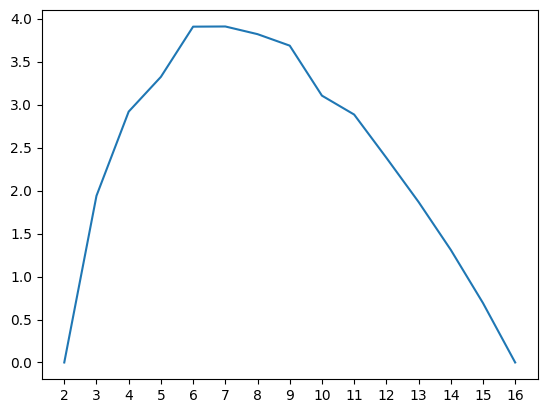

In [386]:
plt.plot(np.arange(len(ds)), ds)
plt.xticks(ticks=np.arange(len(ds)), labels=np.arange(len(ds))+2);

In [437]:
ds_penal = np.zeros(len(lls_new))
for i in range(len(lls_new)):
    ds_penal[i]=d(slope, intercept, i, lls_new[i])/(i+2)

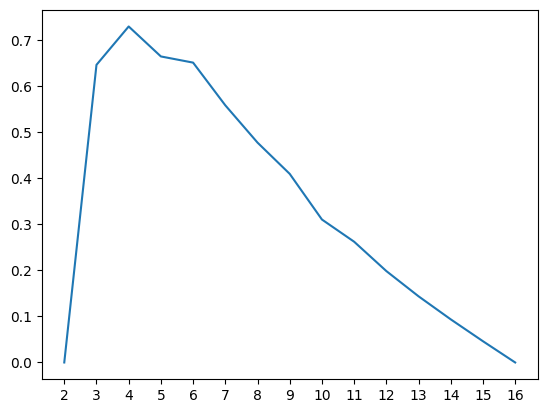

In [438]:
plt.plot(np.arange(len(ds_penal)), ds_penal)
plt.xticks(ticks=np.arange(len(ds_penal)), labels=np.arange(len(ds_penal))+2);

#### Filtering LFP

In [46]:
bands = np.zeros((4, 6, lfp.shape[1])) # 4 bands, 6 channels, 4.5M samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
#Wns = [[1.5,4],[4,10],[10,30],[30,80]] #delta, theta, beta, gamma
for i, Wn in tqdm(enumerate(Wns)): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=1250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, lfp) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
bands = bands[:,:,1250:-1250]
b = np.reshape(bands, (4*6, -1))
b_z = zscore(b, axis=1)
bands.shape,b_z.shape

4it [00:30,  7.58s/it]


((4, 6, 4502203), (24, 4502203))

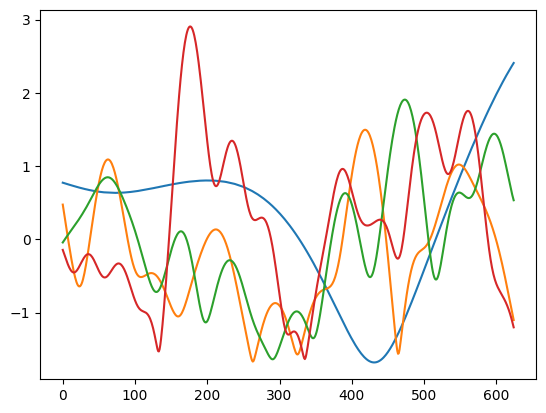

In [47]:
plt.plot(b_z[0,0:int(500/0.8)])
plt.plot(b_z[6,0:int(500/0.8)])
plt.plot(b_z[12,0:int(500/0.8)])
plt.plot(b_z[18,0:int(500/0.8)])

In [36]:
# plotting state
def plot(preds, num=3, time_bin=0.8):
    preds_no_buffer = preds[int(250/time_bin):] # remove buffer
    plt.plot(preds_no_buffer[0:int(750*num/time_bin)])
    start_time = 0
    for i in range(num):
        plt.axvspan(start_time/time_bin, (start_time+250)/time_bin, alpha=0.2, color='red') # stimulus
        start_time += 250
        plt.axvspan(start_time/time_bin, (start_time+500)/time_bin, alpha=0.2, color='gray') # gray
        start_time += 500

#### 4 hidden states

In [48]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -151976320.10312870             +nan
         2 -138883975.82511482 +13092344.27801389
         3 -137462362.09135813 +1421613.73375669
         4 -137374004.89802814  +88357.19332999
         5 -137340211.38368812  +33793.51434001
         6 -137321928.63035196  +18282.75333616
         7 -137310124.25188866  +11804.37846330
         8 -137301617.56371802   +8506.68817064
         9 -137295248.91808867   +6368.64562935
        10 -137290545.82944918   +4703.08863950
        11 -137287058.69855556   +3487.13089362
        12 -137284381.06139389   +2677.63716167
        13 -137282306.37281442   +2074.68857947
        14 -137280677.27149281   +1629.10132161
        15 -137279400.37428308   +1276.89720973
        16 -137278406.46133548    +993.91294760
        17 -137277645.42955542    +761.03178006
        18 -137277075.27745476    +570.15210065
        19 -137276650.25347430    +425.02398047
        20 -137276336.69450483    +313.55896947
        21 -137276098.63481939    +23

3it [00:27,  9.25s/it]


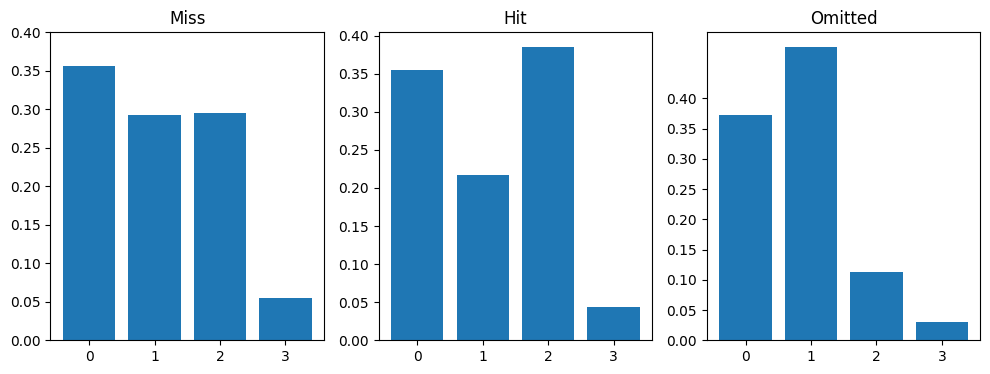

In [49]:
m_t = master_time[1250:-1250]
distribution=np.zeros((3, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

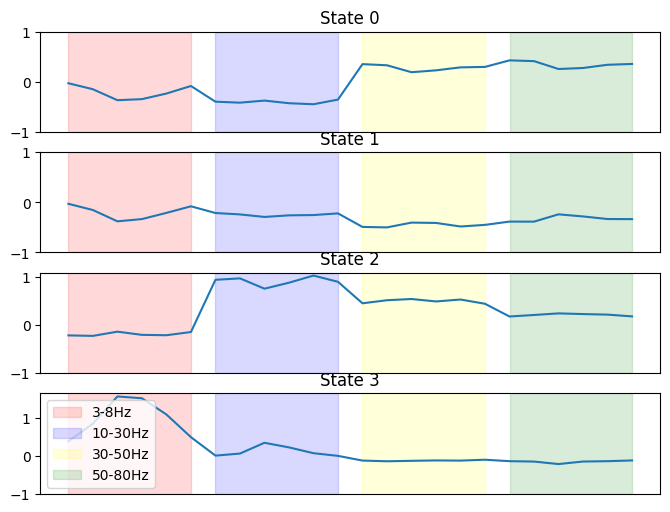

In [50]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

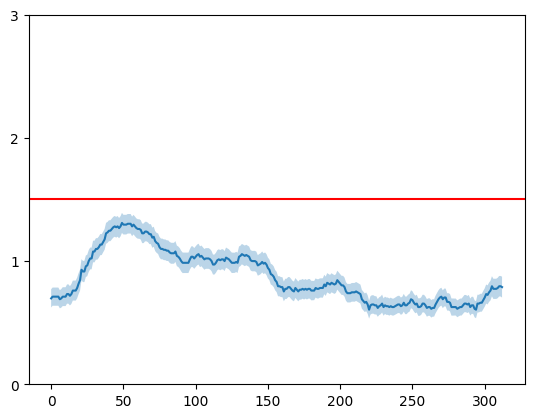

In [57]:
total = np.zeros((len(hit),313))
counter = 0
for i in range(len(hit)):
    arr = preds[find_nearest_idx(m_t, [hit.start_time.values[i]])[0]:find_nearest_idx(m_t, [hit.end_time.values[i]])[0]]
    if len(arr) != 313:
        continue
    counter += 1
    total[i] = arr
total=total[:counter]
plt.plot(np.mean(total, axis=0))
plt.fill_between(np.arange(313), np.mean(total, axis=0)-sem(total, axis=0), np.mean(total, axis=0)+sem(total, axis=0), alpha=0.3)
plt.yticks(np.arange(0,4,1))
plt.axhline(1.5, c='r')

In [58]:
hit_012 = hit[hit['image_name']==imgs[0]]

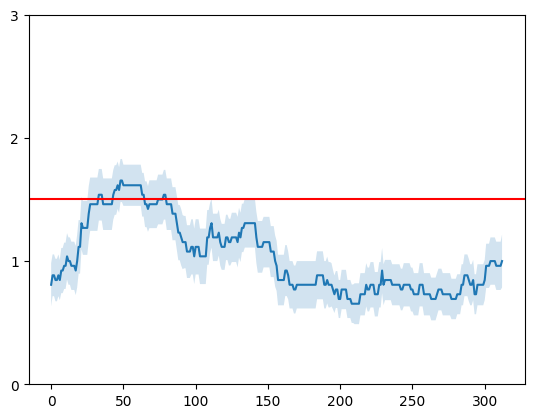

In [59]:
total = np.zeros((len(hit_012),313))
counter = 0
for i in range(len(hit_012)):
    arr = preds[find_nearest_idx(m_t, [hit_012.start_time.values[i]])[0]:find_nearest_idx(m_t, [hit_012.end_time.values[i]])[0]]
    if len(arr) != 313:
        continue
    counter += 1
    total[i] = arr
total = total[:counter]
plt.plot(np.mean(total,axis=0))
plt.fill_between(np.arange(313), np.mean(total,axis=0)-sem(total,axis=0), np.mean(total,axis=0)+sem(total,axis=0), alpha=0.2)
plt.yticks(np.arange(0,4,1))
plt.axhline(1.5, c='r')

In [69]:
model = hmm.GaussianHMM(n_components=3, n_iter=1000, verbose=True, tol=0.1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -154784069.79323342             +nan
         2 -146483345.83287829 +8300723.96035513
         3 -145731066.03862625 +752279.79425204
         4 -145204724.80658698 +526341.23203927
         5 -144759829.43943274 +444895.36715424
         6 -144374041.13746008 +385788.30197266
         7 -143813947.82185605 +560093.31560403
         8 -142109262.44983017 +1704685.37202588
         9 -140369828.74705887 +1739433.70277131
        10 -139996182.70559946 +373646.04145941
        11 -139944116.78541413  +52065.92018533
        12 -139924153.15606615  +19963.62934798
        13 -139915384.51892841   +8768.63713774
        14 -139911146.88893795   +4237.62999046
        15 -139908882.34749669   +2264.54144126
        16 -139907513.10116950   +1369.24632719
        17 -139906519.26945922    +993.83171028
        18 -139905665.43550029    +853.83395892
        19 -139904889.93493232    +775.50056797
        20 -139904174.94102478    +714.99390754
        21 -139903532.29595497    +64

3it [00:36, 12.16s/it]


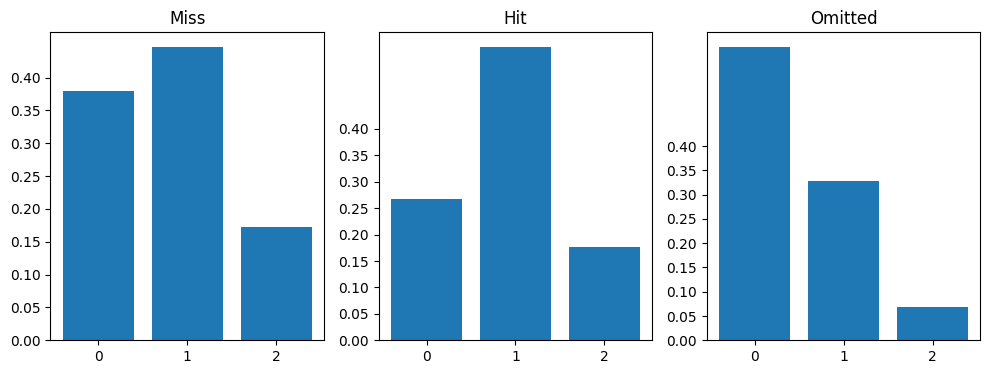

In [70]:
m_t = master_time[1250:-1250]
distribution=np.zeros((3, 3))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].bar(np.arange(3), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(3), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(3), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

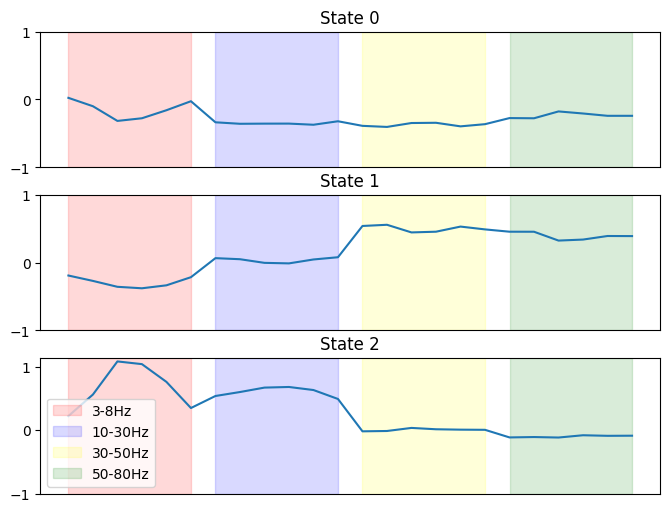

In [71]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

In [60]:
hit_012_prev = sp.loc[hit_012.index-1]

In [61]:
hit_036_012 = sp.loc[hit_012_prev[hit_012_prev.image_name=='im036_r'].index+1]

In [62]:
from scipy.stats import mode

In [63]:
def find_mode(arr):
    result = np.zeros(len(arr))
    counts = np.zeros(len(arr))
    for i in range(len(arr)):
        result[i] = mode(arr[i])[0][0]
        counts[i] = mode(arr[i])[1][0]
    return result, counts

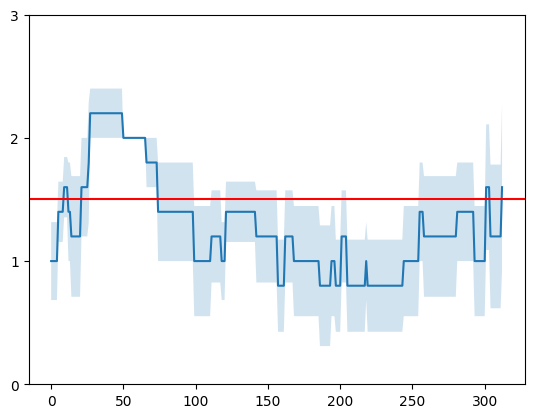

In [64]:
total = np.zeros((len(hit_036_012),313))
counter = 0
for i in range(len(hit_036_012)):
    arr = preds[find_nearest_idx(m_t, [hit_036_012.start_time.values[i]])[0]:find_nearest_idx(m_t, [hit_036_012.end_time.values[i]])[0]]
    if len(arr) != 313:
        continue
    counter += 1
    total[i] = arr
total = total[:counter]
plt.plot(np.mean(total,axis=0))
plt.fill_between(np.arange(313), np.mean(total,axis=0)-sem(total,axis=0), np.mean(total,axis=0)+sem(total,axis=0), alpha=0.2)
plt.yticks(np.arange(0,4,1))
plt.axhline(1.5, c='r')

In [65]:
miss_036 = miss[miss['image_name']==imgs[1]]

In [66]:
miss_036_prev = sp.loc[miss_036.index-1]

In [67]:
miss_111_036 = sp.loc[miss_036_prev[miss_036_prev.image_name=='im111_r'].index+1]

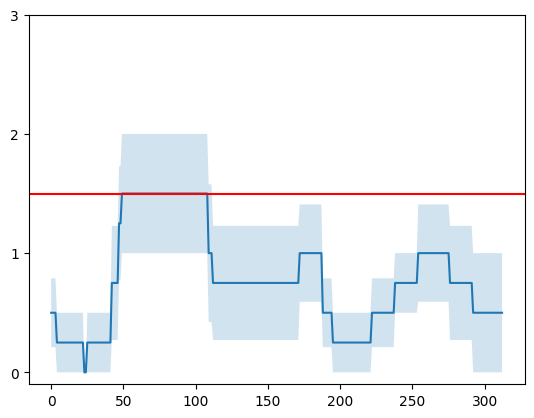

In [68]:
total = np.zeros((len(miss_111_036),313))
counter = 0
for i in range(len(miss_111_036)):
    arr = preds[find_nearest_idx(m_t, [miss_111_036.start_time.values[i]])[0]:find_nearest_idx(m_t, [miss_111_036.end_time.values[i]])[0]]
    if len(arr) != 313:
        continue
    counter += 1
    total[i] = arr
total = total[:counter]
plt.plot(np.mean(total,axis=0))
plt.fill_between(np.arange(313), np.mean(total,axis=0)-sem(total,axis=0), np.mean(total,axis=0)+sem(total,axis=0), alpha=0.2)
plt.yticks(np.arange(0,4,1))
plt.axhline(1.5, c='r')

3it [00:05,  2.00s/it]


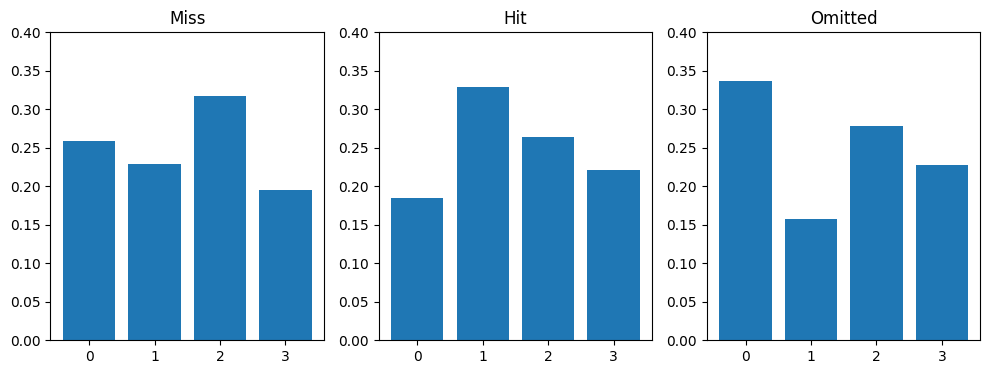

In [99]:
m_t = master_time[250:-250]
distribution=np.zeros((3, 4))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values

    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    stim_mid_idx = (stim_start_idx+stim_end_idx)//2
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:int(stim_mid_idx[i])], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(4), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(4), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(4), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

In [39]:
def plot_means(model, Wns):
    n_state = len(model.means_)
    n_sample = len(model.means_[0])
    fig, axs=plt.subplots(n_state, 1, figsize=(8,8))
    colors = ['r','b','y','g','c','m']
    for i in range(n_state):
        axs[i].bar(np.arange(n_sample), model.means_[i])
        axs[i].set_yticks(np.linspace(-2,2,3))
        start_j = 0
        end_j = 5
        for j in range(len(Wns)):
            axs[i].axvspan(start_j, end_j, alpha=0.15, color=colors[j], label=f'{Wns[j][0]}-{Wns[j][1]}Hz')
            start_j += 6
            end_j += 6
        axs[i].set_title(f'State {i}')
    fig.legend()

In [29]:
def plot_dist(master_time, stim, preds, num, ylim):
    y_inc = ylim/5
    ylim = y_inc*5+0.01
    m_t = master_time[100:]
    all_stims = np.unique(stim['image_name'].values)
    u_mask = np.ones(len(m_t), dtype=int)
    distribution=np.zeros((10,num))
    for s_idx, s in tqdm(enumerate(all_stims)):
        stim_start = stim[stim['image_name'] == s].start_time.values
        stim_end = stim[stim['image_name'] == s].end_time.values
        stim_start_idx = find_nearest_idx(m_t, stim_start)
        stim_end_idx = find_nearest_idx(m_t, stim_end)
        for i, idx in enumerate(stim_start_idx):
            unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
            u_mask[stim_start_idx[i]:stim_end_idx[i]] = 0
            for j, u in enumerate(unique):
                distribution[s_idx][u] += counts[j]
    u_preds=preds[u_mask==1]
    unique, counts = np.unique(u_preds, return_counts=True)

    for i, u in enumerate(unique):
        distribution[-1][u] += counts[i]
    d = deepcopy(distribution)
    for i in range(10):
        d[i] = d[i]/np.sum(d[i])
    fig, axs = plt.subplots(3, 4,figsize=(15,12))
    for i in range(3):
        for j in range(4):
            try:
                axs[i][j].bar(np.arange(num), d[i*4+j])
            except:
                axs[i][j].axis('off')
                continue
            try:
                axs[i][j].set_title(all_stims[i*4+j])
            except:
                axs[i][j].set_title('gray')
            
            axs[i][j].set_yticks(np.arange(0,ylim,y_inc))

9it [01:06,  7.37s/it]


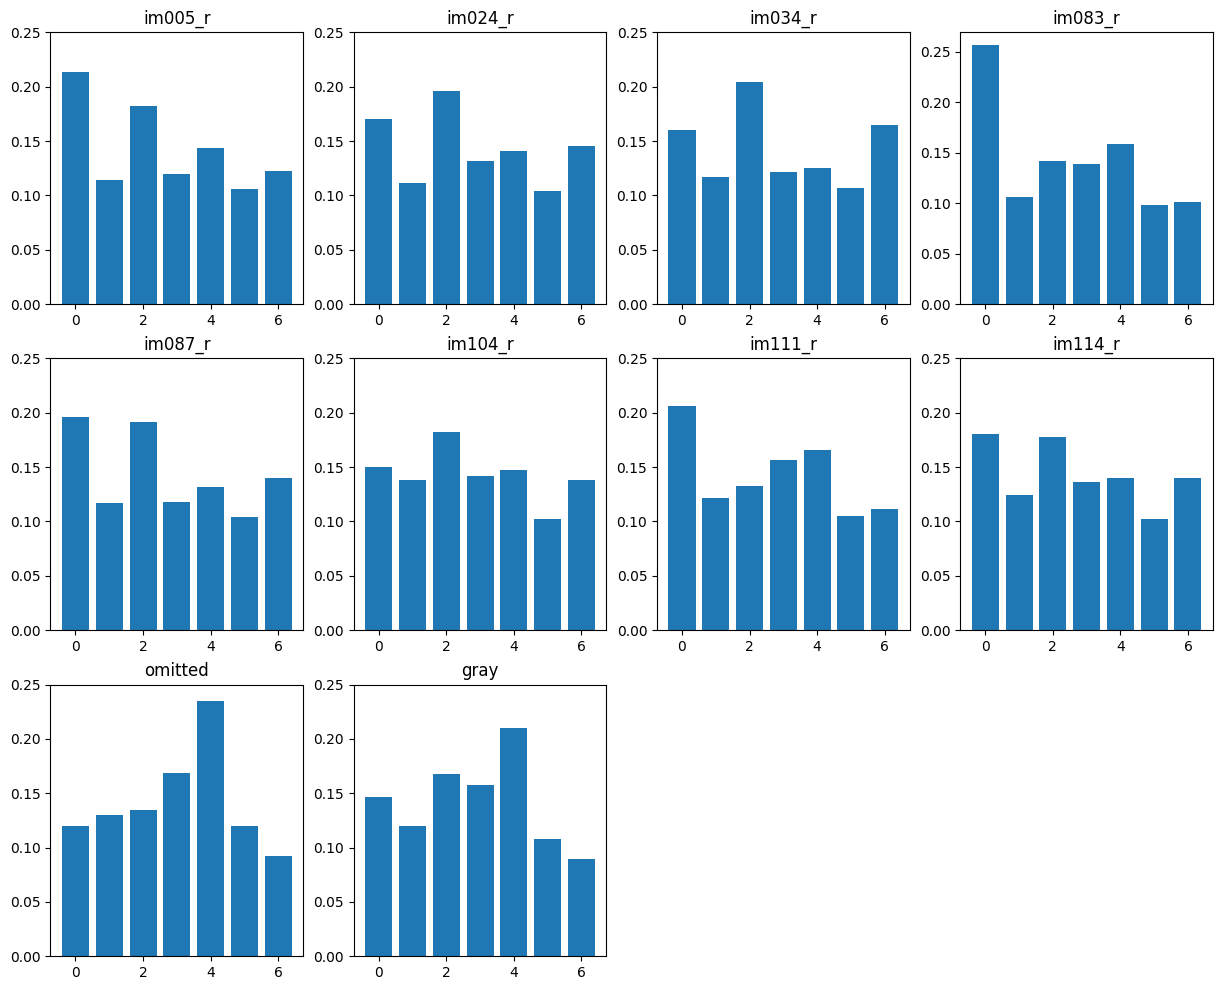

In [417]:
plot_dist(master_time, stim, preds, 7)

#### 7 hidden states

In [139]:
model = hmm.GaussianHMM(n_components=7, n_iter=1000, verbose=True, tol=0.1)
model.fit(b_z.T)
preds = model.predict(b_z.T)

         1 -30438433.40545312             +nan
         2 -27626771.72397177 +2811661.68148135
         3 -26256345.62671513 +1370426.09725663
         4 -25853600.20248668 +402745.42422845
         5 -25788590.08579929  +65010.11668739
         6 -25766485.96005420  +22104.12574508
         7 -25755268.81146418  +11217.14859002
         8 -25747789.18224397   +7479.62922021
         9 -25742147.11638859   +5642.06585538
        10 -25737934.31661169   +4212.79977690
        11 -25734833.92534499   +3100.39126670
        12 -25732578.73046005   +2255.19488494
        13 -25730866.79579204   +1711.93466800
        14 -25729550.39937799   +1316.39641405
        15 -25728529.88810449   +1020.51127350
        16 -25727758.31958620    +771.56851828
        17 -25727157.05985219    +601.25973402
        18 -25726666.09933399    +490.96051819
        19 -25726258.75030476    +407.34902924
        20 -25725904.07795963    +354.67234512
        21 -25725593.48863264    +310.58932700
        22 

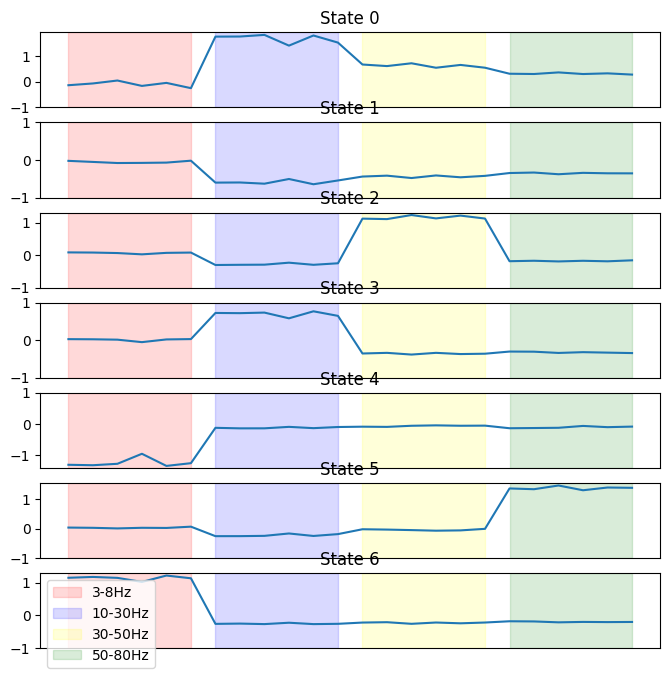

In [141]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,8))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

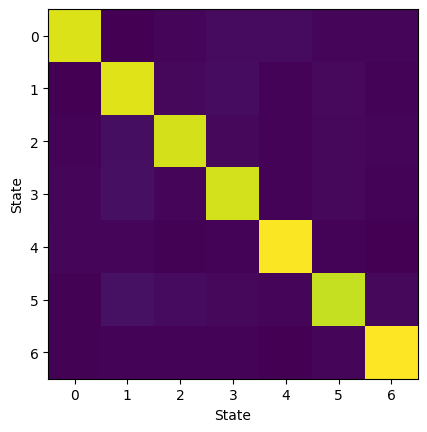

In [143]:
plt.imshow(model.transmat_)
plt.xlabel('State')
plt.ylabel('State');

3it [00:06,  2.27s/it]


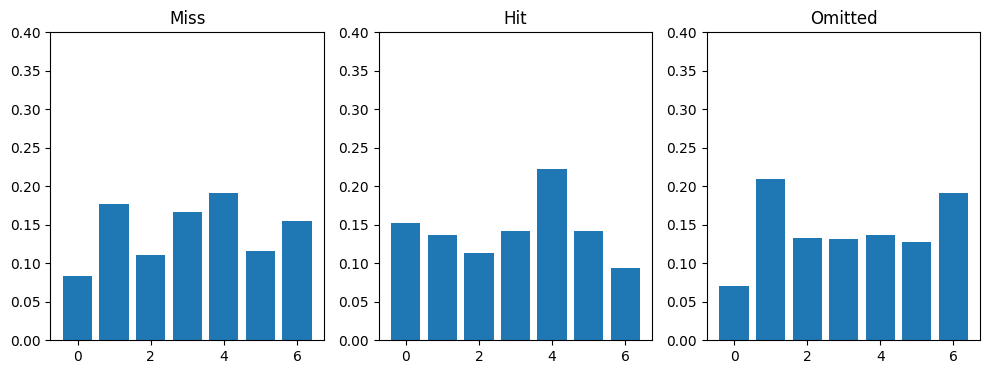

In [147]:
m_t = master_time[250:-250]
distribution=np.zeros((3, 7))
stimuli = [miss, hit, omitted]
for s_idx, s in tqdm(enumerate(stimuli)):
    stim_start = s.start_time.values
    stim_end = s.end_time.values
    stim_start_idx = find_nearest_idx(m_t, stim_start)
    stim_end_idx = find_nearest_idx(m_t, stim_end)
    for i, idx in enumerate(stim_start_idx):
        unique, counts = np.unique(preds[stim_start_idx[i]:stim_end_idx[i]], return_counts=True)
        for j, u in enumerate(unique):
            distribution[s_idx][u] += counts[j]
d = deepcopy(distribution)
for i in range(3):
    d[i] = d[i]/np.sum(d[i])
fig, axs = plt.subplots(1, 3,figsize=(12,4))
axs[0].bar(np.arange(7), d[0])
axs[0].set_title('Miss')
axs[0].set_yticks(np.arange(0,0.41,0.05))
axs[1].bar(np.arange(7), d[1])
axs[1].set_title('Hit')
axs[1].set_yticks(np.arange(0,0.41,0.05));
axs[2].bar(np.arange(7), d[2])
axs[2].set_title('Omitted')
axs[2].set_yticks(np.arange(0,0.41,0.05));

Text(0, 0.5, 'difference %')

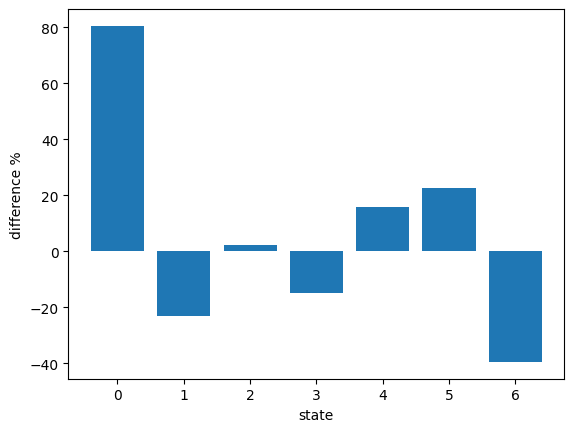

In [157]:
diff=(d[1]-d[0])/d[0]
plt.bar(np.arange(7), diff*100)
plt.xlabel('state')
plt.ylabel('difference %')

<BarContainer object of 63 artists>

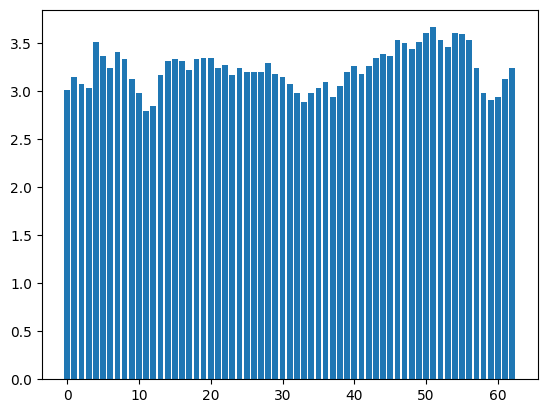

In [162]:
total = np.zeros(63)
counter = 0
for i in range(len(miss)):
    arr = preds[find_nearest_idx(m_t, [miss.start_time.values[i]])[0]:find_nearest_idx(m_t, [miss.end_time.values[i]])[0]]
    if len(arr) != 63:
        continue
    counter += 1
    total += arr
total = total/counter
plt.bar(np.arange(63), total)

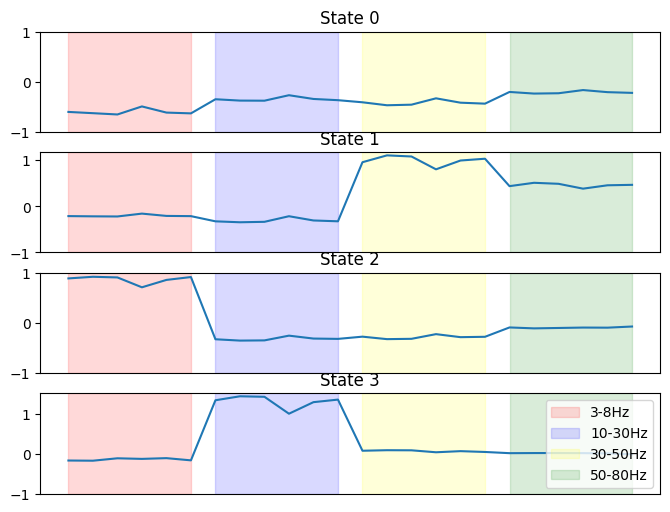

In [123]:
fig, axs=plt.subplots(len(model1.means_),1,figsize=(8,6))
for i in range(len(model1.means_)):
    axs[i].plot(model1.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 5, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(6, 11, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(12, 17, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(18, 23, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

In [96]:
mask = np.arange(0,96,6)
all_channels = lfpC_copy[:,mask].T

In [97]:
all_channels.shape

(16, 900941)

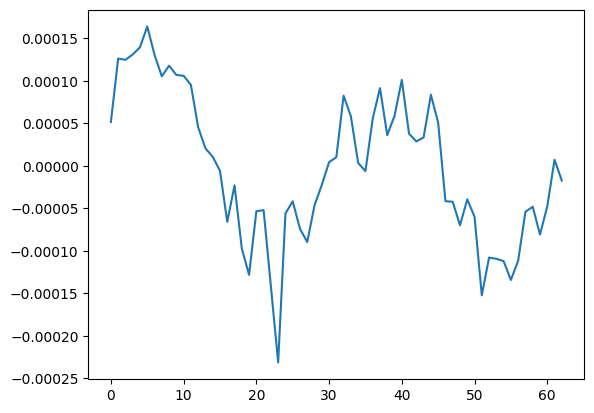

In [163]:
a = A_chan[:,0]
plt.plot(a[find_nearest_idx(master_time, [miss.start_time.values[0]])[0]:find_nearest_idx(master_time, [miss.end_time.values[0]])[0]])

In [177]:
500/0.8

625.0

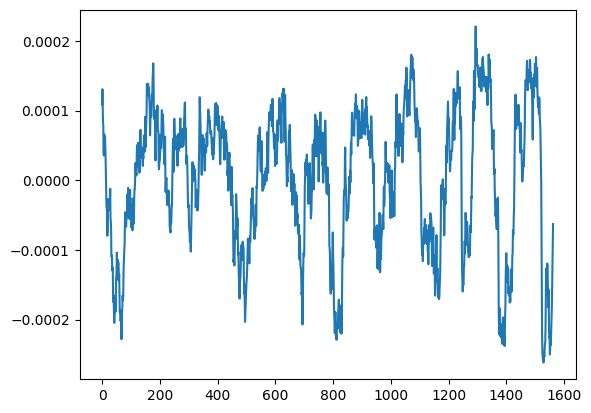

In [178]:
a = A_chan[:,0]
a_sec = a[find_nearest_idx(master_time, [hit.start_time.values[0]-0.5])[0]:find_nearest_idx(master_time, [hit.end_time.values[0]+0.5])[0]]
plt.plot(a_sec)

In [184]:
f,t,sxx = spectrogram(a_sec, fs=1250, nperseg=25)

In [185]:
f.shape, sxx.shape

((13,), (13, 70))

In [186]:
f

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
       550., 600.])

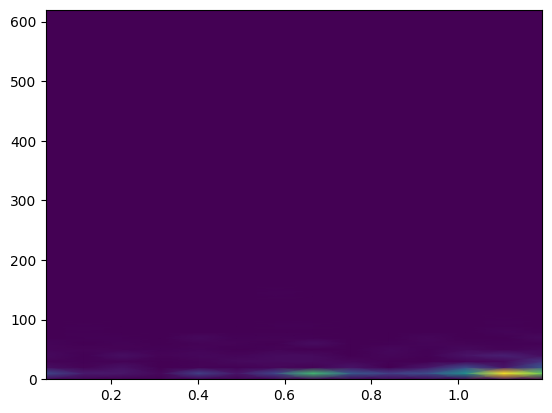

In [181]:
plt.pcolormesh(t, f, sxx, shading='gouraud')

In [98]:
bands = np.zeros((4, 16, len(C_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env)
    bands[i] = all_channels_env_abs
bands = np.reshape(bands,(4*16, len(A_chan)))
bands = bands[:,100:].T
bands_z_0 = zscore(bands, axis=0)
print(bands.shape)
print(bands_z_0.shape)

(900841, 64)
(900841, 64)


In [99]:
model = hmm.GaussianHMM(n_components=4, n_iter=1000, verbose=True, tol=0.1)
model.fit(bands_z_0)
preds = model.predict(bands_z_0)

         1 -79654927.74559742             +nan
         2 -75007807.47834232 +4647120.26725510
         3 -74223612.75211824 +784194.72622408
         4 -74147337.72272930  +76275.02938895
         5 -74121001.43709689  +26336.28563240
         6 -74106131.96378104  +14869.47331585
         7 -74095817.95151670  +10314.01226434
         8 -74088111.52348438   +7706.42803232
         9 -74082195.72579899   +5915.79768538
        10 -74077632.25421530   +4563.47158369
        11 -74074027.68527034   +3604.56894496
        12 -74071032.85081024   +2994.83446009
        13 -74068463.05794869   +2569.79286155
        14 -74066236.02721395   +2227.03073475
        15 -74064191.07145339   +2044.95576055
        16 -74062255.43977113   +1935.63168226
        17 -74060486.00111635   +1769.43865478
        18 -74058889.16731597   +1596.83380038
        19 -74057409.93411426   +1479.23320171
        20 -74056047.32094660   +1362.61316766
        21 -74054785.12680927   +1262.19413733
        22 -

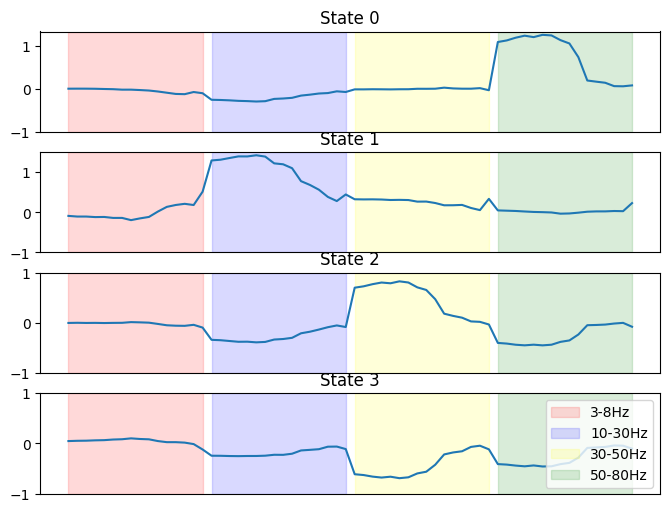

In [100]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].plot(model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

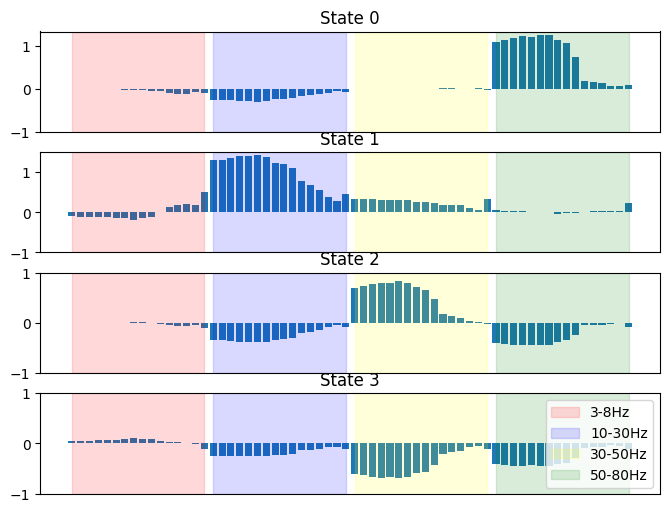

In [303]:
fig, axs=plt.subplots(len(model.means_),1,figsize=(8,6))
for i in range(len(model.means_)):
    axs[i].bar(np.arange(64), model.means_[i])
    axs[i].set_yticks(np.linspace(-1.,1.,3))
    #axs[i].axhlines(0, 0, len(model.means_[i]), color='r')
    axs[i].axvspan(0, 15, alpha=0.15, color='red', label='3-8Hz')
    axs[i].axvspan(16, 31, alpha=0.15, color='blue', label='10-30Hz')
    axs[i].axvspan(32, 47, alpha=0.15, color='yellow', label='30-50Hz')
    axs[i].axvspan(48, 63, alpha=0.15, color='green', label='50-80Hz')
    axs[i].set_title(f'State {i}')
    axs[i].xaxis.set_ticks([])
plt.legend();

#### Power Spectrum

In [12]:
bands = np.zeros((4, 6, len(A_chan))) # 4 bands, 6 channels, 450k samples
Wns = [[3,8],[10,30],[30,50],[50,80]]
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i, Wn in enumerate(Wns): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=Wn, fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, all_channels) 
    all_channels_env = hilbert(all_channels_ff)
    all_channels_env_abs = np.abs(all_channels_env) # type: ignore
    bands[i] = all_channels_env_abs
print(bands.shape)
bands = bands[:,:,250:-250]
print(bands.shape)

(4, 6, 901341)
(4, 6, 900841)


In [14]:
master_time.shape

(901341,)

In [15]:
m_t = master_time[250:-250]

In [45]:
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values-0.250)
hit_ends = find_nearest_idx(m_t, hit.end_time.values+0.5)
miss_starts = find_nearest_idx(m_t, miss.start_time.values-0.250)
miss_ends = find_nearest_idx(m_t, miss.end_time.values+0.5) 
omit_starts = find_nearest_idx(m_t, omitted.start_time.values-0.250)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values+0.5)

In [44]:
# differentiating hit and miss trials
hit_env = np.zeros((4, 250))
miss_env = np.zeros((4, 250))
omit_env = np.zeros((4, 250))
hit_err = 0
miss_err = 0
omit_err = 0
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = np.mean(env[:,hit_starts[j]:hit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                hit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        hit_env[i] += avg
    for j in range(len(miss_starts)):
        avg = np.mean(env[:,miss_starts[j]:miss_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                miss_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        miss_env[i] += avg
    for j in range(len(omit_starts)):
        avg = np.mean(env[:,omit_starts[j]:omit_ends[j]],axis=0)
        if len(avg) < 250:
            if len(avg) < 250*0.95:
                omit_err+=1
                continue
            else:
                avg = np.append(avg, avg[-1]*(int(250-len(avg))))
        if len(avg) > 250:
            avg = avg[:250]
        omit_env[i] += avg

In [48]:
# differentiating hit and miss trials
hit_err = 0
miss_err = 0
omit_err = 0
hit_all = np.zeros((4, len(hit_starts), 6, 250))
miss_all = np.zeros((4, len(miss_starts), 6, 250))
omit_all = np.zeros((4, len(omit_starts), 6, 250))
for i in range(4):
    env = all_env[i]
    for j in range(len(hit_starts)):
        avg = env[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        hit_all[i][j] = avg
    for j in range(len(miss_starts)):
        avg = env[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        miss_all[i][j] = avg
    for j in range(len(omit_starts)):
        avg = env[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < 250:
            if avg.shape[1] < 250*0.95:
                omit_err+=1
                continue
        if avg.shape[1] > 250:
            avg = avg[:, :250]
        omit_all[i][j] = avg

In [56]:
hs = np.reshape(hit_all, (4, len(hit_starts)*6, 250))
ms = np.reshape(miss_all, (4, len(miss_starts)*6, 250))
os = np.reshape(omit_all, (4, len(omit_starts)*6, 250))

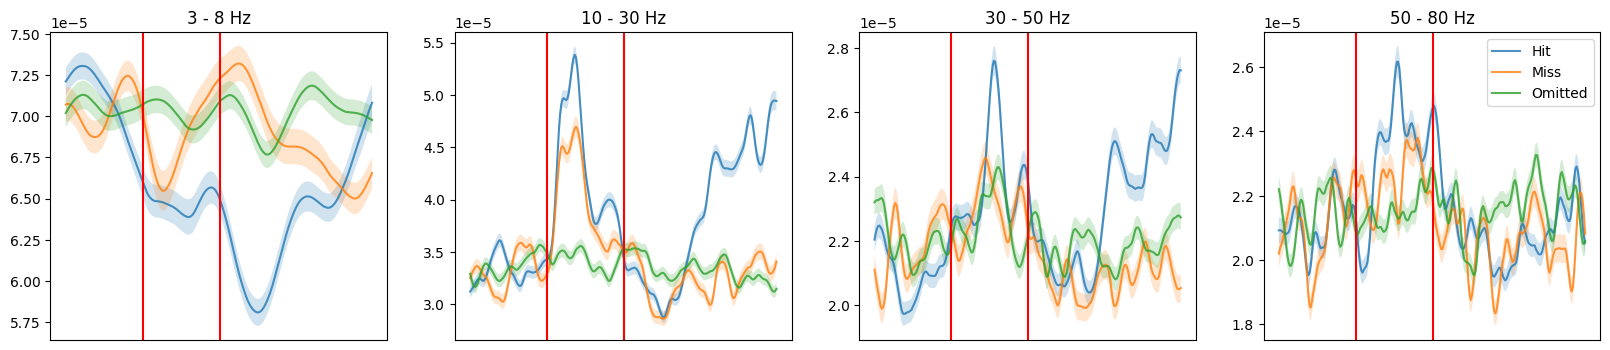

In [86]:
fig, axs = plt.subplots(1,4,figsize=(20,4))
Wns = [[3,8],[10,30],[30,50],[50,80]]
for i, ax in enumerate(axs):
    h = hs[i]
    m = ms[i]
    o = os[i]
    ax.plot(np.mean(h, axis=0), alpha=0.8, label='Hit')
    ax.fill_between(np.arange(250), np.mean(h, axis=0)-sem(h, axis=0), np.mean(h, axis=0)+sem(h, axis=0), alpha=0.2)
    ax.plot(np.mean(m, axis=0), alpha=0.8, label='Miss')
    ax.fill_between(np.arange(250), np.mean(m, axis=0)-sem(m, axis=0), np.mean(m, axis=0)+sem(m, axis=0), alpha=0.2)
    ax.plot(np.mean(o, axis=0), alpha=0.8, label='Omitted')
    ax.fill_between(np.arange(250), np.mean(o, axis=0)-sem(o, axis=0), np.mean(o, axis=0)+sem(o, axis=0), alpha=0.2)
    ax.axvline(250/4, color='r')
    ax.axvline(500/4, color='r')
    ax.xaxis.set_ticks([])
    ax.set_title(f'{Wns[i][0]} - {Wns[i][1]} Hz')
plt.legend();

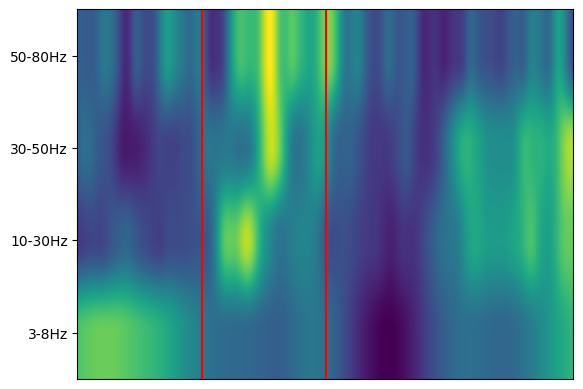

In [235]:
temp=np.array([zscore(np.mean(hs[3], axis=0)),zscore(np.mean(hs[2], axis=0)), zscore(np.mean(hs[1], axis=0)), zscore(np.mean(hs[0], axis=0)),])
plt.imshow(temp, aspect='auto')
plt.axvline(250/4, color='r')
plt.axvline(500/4, color='r')
plt.xticks([]);
plt.yticks([0,1,2,3],['50-80Hz','30-50Hz','10-30Hz','3-8Hz']);

In [245]:
n_f = 100
duration = 250
n_probe = 6

In [246]:
real = np.zeros((n_f, 6, len(A_chan)))
imag = np.zeros((n_f, 6, len(A_chan)))
powers = np.zeros((n_f, 6, len(A_chan)))
Wns = np.arange(1,102,1)
all_channels = np.vstack((A_chan, B_chan, C_chan, D_chan, E_chan, F_chan))
for i in tqdm(range(len(Wns)-1)):
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos')
    all_channels_ff = sosfiltfilt(sos, all_channels)
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env) # type: ignore
    imag[i] = np.imag(all_channels_env) # type: ignore
    powers[i] = real[i]**2 + imag[i]**2
print(powers.shape) # 100 bands, 6 channels(1 channel/probe), 900k samples

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: The length of the input vector x must be greater than padlen, which is 21.

In [231]:
ps = powers[:,:,250:-250]
ps.shape

(10, 6, 900841)

In [232]:

hit_p = np.zeros((n_f, len(hit_starts), n_probe, duration))
miss_p = np.zeros((n_f, len(miss_starts), n_probe, duration))
omit_p = np.zeros((n_f, len(omit_starts), n_probe, duration))
for i in range(n_f):
    p = ps[i]
    for j in range(len(hit_starts)):
        avg = p[:,hit_starts[j]:hit_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        hit_p[i][j] = zscore(avg, axis=1)
    for j in range(len(miss_starts)):
        avg = p[:,miss_starts[j]:miss_ends[j]]
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        miss_p[i][j] = zscore(avg, axis=1)
    for j in range(len(omit_starts)):
        avg = p[:,omit_starts[j]:omit_ends[j]]
        if avg.shape[1] < duration:
            if avg.shape[1] < duration*0.95:
                continue
        if avg.shape[1] > duration:
            avg = avg[:, :duration]
        omit_p[i][j] = zscore(avg, axis=1)

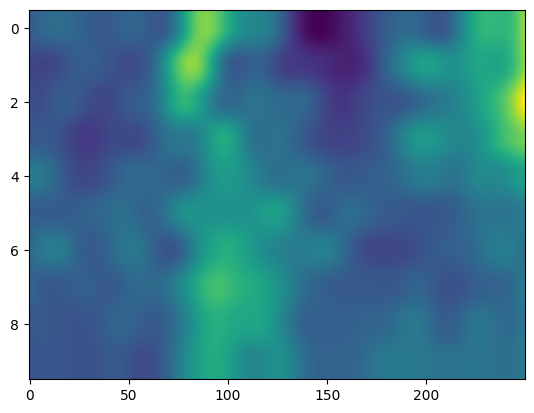

In [233]:
h_p = np.reshape(hit_p, (n_f, len(hit_starts) * n_probe, duration))
h_p_avg = np.mean(h_p, axis=1)
plt.imshow(h_p_avg, aspect='auto')

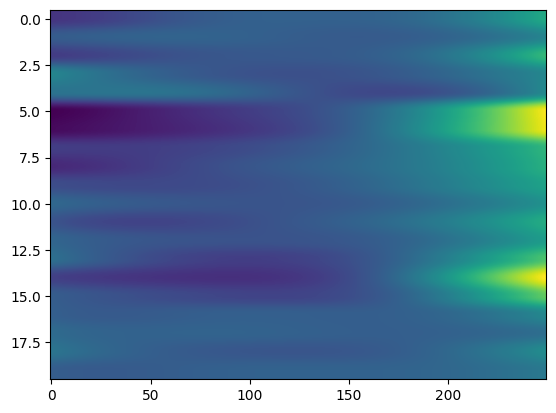

In [216]:
plt.imshow(h_p_avg[10:30], aspect='auto')




In [197]:
f1 = h_p_avg[1]
np.sum(f1)

0.0

In [259]:
# differentiating hit and miss trials
hit_env = np.zeros(100)
miss_env = np.zeros(100)
omit_env = np.zeros(100)
all_env = deepcopy(bands)
hit_starts = find_nearest_idx(m_t, hit.start_time.values)
hit_ends = find_nearest_idx(m_t, hit.end_time.values)
miss_starts = find_nearest_idx(m_t, miss.start_time.values)
miss_ends = find_nearest_idx(m_t, miss.end_time.values)
omit_starts = find_nearest_idx(m_t, omitted.start_time.values)
omit_ends = find_nearest_idx(m_t, omitted.end_time.values)
for i in tqdm(range(100)):
    env = all_env[i]
    for j in range(len(hit_starts)):
        hit_env[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

100%|██████████| 100/100 [00:00<00:00, 313.62it/s]


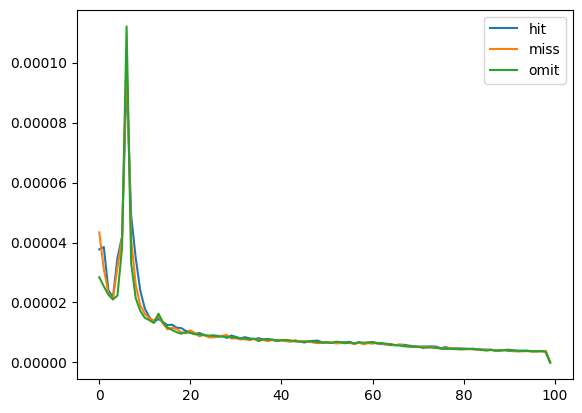

In [293]:
plt.plot(np.arange(100), hit_env/hit_count, label='hit')
plt.plot(np.arange(100), miss_env/miss_count, label='miss')
plt.plot(np.arange(100), omit_env/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [287]:
powers = np.zeros((100, 6, len(A_chan)))
real = np.zeros((100, 6, len(A_chan)))
imag = np.zeros((100, 6, len(A_chan)))
Wns = np.arange(1,101,1)
for i in tqdm(range(len(Wns)-1)): # checked, same output with processing each channel individually
    sos = butter(N=3, Wn=[Wns[i], Wns[i+1]], fs=250, btype='bandpass', output='sos') # butterworth
    all_channels_ff = sosfiltfilt(sos, A_chan) 
    all_channels_env = hilbert(all_channels_ff)
    real[i] = np.real(all_channels_env)
    imag[i] = np.imag(all_channels_env)
    powers[i] = real[i]**2 + imag[i]**2

100%|██████████| 99/99 [00:35<00:00,  2.77it/s]


In [299]:
imag[0].mean(axis=1)

array([1.92460287e-24, 1.92460287e-24, 1.92460287e-24, 1.92460287e-24,
       1.92460287e-24, 1.92460287e-24])

In [298]:
imag[0].mean(axis=0).mean()

-5.773808611757838e-24

In [285]:
# differentiating hit and miss trials
hit_env2 = np.zeros(100)
miss_env2 = np.zeros(100)
omit_env2 = np.zeros(100)
print(powers.shape)
all_env2 = deepcopy(powers)[:,:,250:-250]
print(all_env2.shape)
for i in range(100):
    env = all_env2[i]
    for j in range(len(hit_starts)):
        hit_env2[i] += np.sum(env[:,hit_starts[j]:hit_ends[j]])
    for j in range(len(miss_starts)):
        miss_env2[i] += np.sum(env[:,miss_starts[j]:miss_ends[j]])
    for j in range(len(omit_starts)):
        omit_env2[i] += np.sum(env[:,omit_starts[j]:omit_ends[j]])

(100, 6, 901341)
(100, 6, 900841)


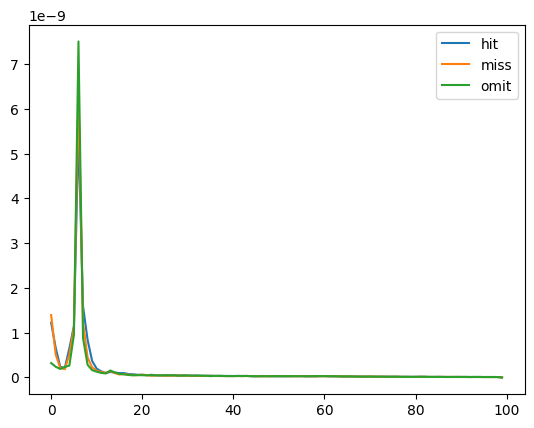

In [286]:
plt.plot(np.arange(100), hit_env2/hit_count, label='hit')
plt.plot(np.arange(100), miss_env2/miss_count, label='miss')
plt.plot(np.arange(100), omit_env2/omit_count, label='omit')
#plt.xticks(ticks=np.arange(4), labels=['3-8Hz','10-30Hz','30-50Hz','50-80Hz'])
plt.legend()

In [183]:
f,t,zxx = stft(A_chan, fs=250, nperseg=1)

In [184]:
np.sum(np.imag(zxx[0]))

0.0

In [129]:
sos = butter(N=3, Wn=[1,2], fs=250, btype='bandpass', output='sos')
all_channels_ff = sosfiltfilt(sos, A_chan)[250:-250]

In [141]:
a_stft = stft(all_channels_ff, fs=250)

In [145]:
len(a_stft)

3

In [146]:
f = a_stft[0]
t = a_stft[1]
zxx = a_stft[2]

In [161]:
from scipy.signal import spectrogram

In [168]:
B_chan

<xarray.DataArray 'LFP' (time: 901341)>
array([ 8.11200e-05,  1.45080e-04,  1.11150e-04, ..., -1.45860e-04,
       -6.31800e-05, -1.11735e-04], dtype=float32)
Coordinates:
  * time     (time) float64 24.24 24.25 24.25 ... 3.63e+03 3.63e+03 3.63e+03
    channel  int64 1145244967

In [171]:
f,t,sxx = spectrogram(np.vstack(A_chan.values), fs=250)

##### Spectrogram

In [120]:
hit_start_2 = find_nearest_idx(master_time, [hit.iloc[2].start_time])[0]
hit_end_2 = find_nearest_idx(master_time, [hit.iloc[2].end_time])[0]
a_chan_sec = A_chan[hit_start_2:hit_end_2,0]

In [121]:
a_chan_sec.shape

(62,)

In [133]:
f,t,sxx = spectrogram(a_chan_sec, fs=250, nperseg=30)

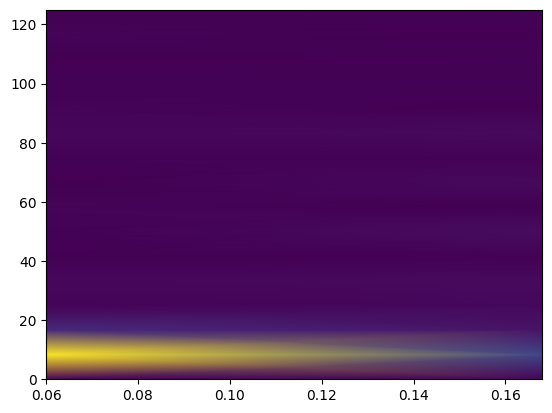

In [135]:
plt.pcolormesh(t, f, sxx, shading='gouraud')